# import libraries

In [176]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest,f_classif
import shap

#   Import Datset

In [177]:
df = pd.read_csv("Dataset/Students_Grading_Dataset_Biased.csv")
df.head(3)

,Student_ID,First_Name,Last_Name,Email,Gender,Age,Department,Attendance (%),Midterm_Score,Final_Score,...,Projects_Score,Total_Score,Grade,Study_Hours_per_Week,Extracurricular_Activities,Internet_Access_at_Home,Parent_Education_Level,Family_Income_Level,Stress_Level (1-10),Sleep_Hours_per_Night
0,S1000,Omar,Williams,student0@university.com,Female,22,Engineering,52.29,55.03,57.82,...,85.90,56.09,F,6.2,No,Yes,High School,Medium,5,4.7
1,S1001,Maria,Brown,student1@university.com,Male,18,Engineering,97.27,97.23,45.80,...,55.65,50.64,A,19.0,No,Yes,NaN,Medium,4,9.0
2,S1002,Ahmed,Jones,student2@university.com,Male,24,Business,57.19,67.05,93.68,...,73.79,70.30,D,20.7,No,Yes,Master's,Low,6,6.2


# Data type analysis

In [178]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 23 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Student_ID                  5000 non-null   object 
 1   First_Name                  5000 non-null   object 
 2   Last_Name                   5000 non-null   object 
 3   Email                       5000 non-null   object 
 4   Gender                      5000 non-null   object 
 5   Age                         5000 non-null   int64  
 6   Department                  5000 non-null   object 
 7   Attendance (%)              4484 non-null   float64
 8   Midterm_Score               5000 non-null   float64
 9   Final_Score                 5000 non-null   float64
 10  Assignments_Avg             4483 non-null   float64
 11  Quizzes_Avg                 5000 non-null   float64
 12  Participation_Score         5000 non-null   float64
 13  Projects_Score              5000 

# Exploratory data analysis
Generally performed on X_train but main goal of this project is to do EDA. <br>
Hence it is performed on whole dataset.

# Drop unnecessory columns

In [179]:
df = df.drop(labels=['Student_ID','First_Name','Last_Name','Email'],axis=1)

In [180]:
print("number of nominal columns")
print(df.select_dtypes(include='object').shape[1])
print()
print("number of numerical columns")
print(df.select_dtypes(exclude='object').shape[1])


number of nominal columns
7

number of numerical columns
12


# Missing values

In [181]:
df.isna().sum()

Gender                           0
Age                              0
Department                       0
Attendance (%)                 516
Midterm_Score                    0
Final_Score                      0
Assignments_Avg                517
Quizzes_Avg                      0
Participation_Score              0
Projects_Score                   0
Total_Score                      0
Grade                            0
Study_Hours_per_Week             0
Extracurricular_Activities       0
Internet_Access_at_Home          0
Parent_Education_Level        1794
Family_Income_Level              0
Stress_Level (1-10)              0
Sleep_Hours_per_Night            0
dtype: int64

In [182]:
print('% missing values w.r.t. total obs')
print('-'*50)
print("Attendance (%)")
print(round((df.isna().sum()['Attendance (%)'])/df.shape[0]*100,2))
print("Assignments_Avg")
print(round((df.isna().sum()['Assignments_Avg'])/df.shape[0]*100,2))
print("Parent_Education_Level")
print(round((df.isna().sum()['Parent_Education_Level'])/df.shape[0]*100,2))

% missing values w.r.t. total obs
--------------------------------------------------
Attendance (%)
10.32
Assignments_Avg
10.34
Parent_Education_Level
35.88


## Missing value treatment
We will drop Parent_Education_Level as % of missing values is large.<br>
Imputaing 35% data won't make sense.<br>
For % attendance and Assignment_Avg we will impute these with mean.

In [183]:
df['Assignments_Avg'] = df['Assignments_Avg'].fillna(df['Assignments_Avg'].mean())
df['Attendance (%)'] = df['Attendance (%)'].fillna(df['Attendance (%)'].mean())
df = df.drop(labels='Parent_Education_Level',axis=1)

# Categorical column analysis

In [184]:
cat_df = df.select_dtypes(include='object')
cat_df

,Gender,Department,Grade,Extracurricular_Activities,Internet_Access_at_Home,Family_Income_Level
0,Female,Engineering,F,No,Yes,Medium
1,Male,Engineering,A,No,Yes,Medium
2,Male,Business,D,No,Yes,Low
3,Female,Mathematics,A,Yes,Yes,High
4,Female,CS,F,Yes,Yes,High
...,...,...,...,...,...,...
4995,Male,Business,D,No,Yes,Low
4996,Male,Business,C,No,Yes,Medium
4997,Female,CS,A,Yes,No,Medium
4998,Male,CS,A,Yes,Yes,Low


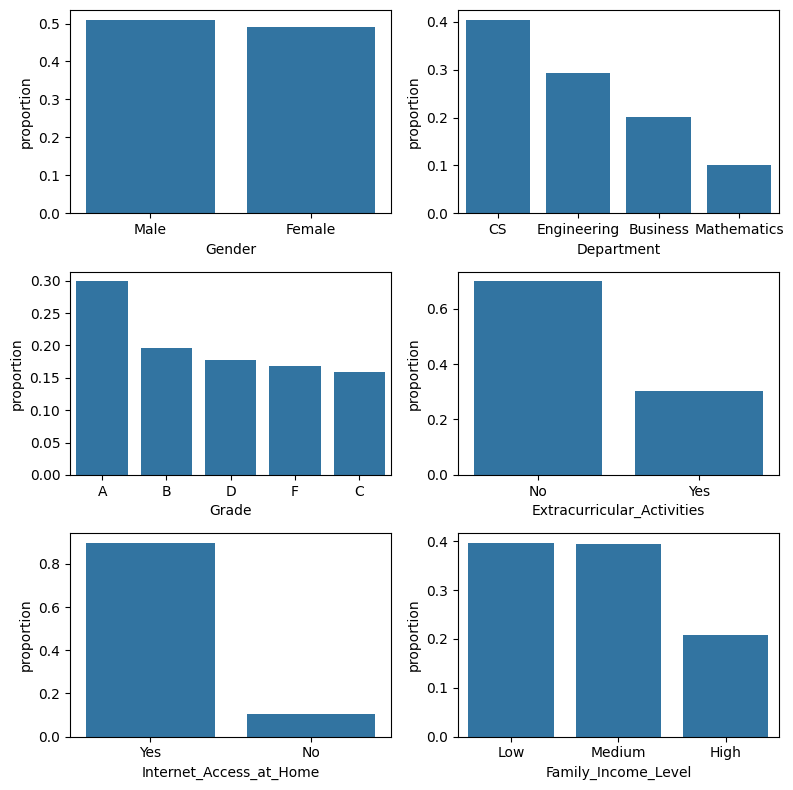

In [185]:
plt.figure(figsize=[8,8])
for plot,i in enumerate(cat_df):
    plt.subplot(3,2,plot+1)
    sns.barplot(cat_df[i].value_counts(normalize=True))
plt.tight_layout()
plt.show()

In [186]:
data = pd.concat([cat_df,df[['Total_Score','Age','Attendance (%)','Midterm_Score',
       'Final_Score', 'Assignments_Avg', 'Quizzes_Avg', 'Participation_Score',
       'Projects_Score','Sleep_Hours_per_Night']]],axis=1)

for i in cat_df:
    result = data.groupby(by=i)[['Total_Score','Age','Attendance (%)','Midterm_Score',
       'Final_Score', 'Assignments_Avg', 'Quizzes_Avg', 'Participation_Score',
       'Projects_Score','Sleep_Hours_per_Night']].mean().T
    print('mean by ')
    print(result)
    print('-'*75)

mean by 
Gender                    Female       Male
Total_Score            75.265762  74.983603
Age                    21.076358  21.021560
Attendance (%)         75.517189  75.349060
Midterm_Score          70.087624  70.556499
Final_Score            69.586721  69.692693
Assignments_Avg        74.936234  74.666611
Quizzes_Avg            74.914349  74.907252
Participation_Score     5.019669   4.941964
Projects_Score         74.984720  74.867393
Sleep_Hours_per_Night   6.480482   6.495492
---------------------------------------------------------------------------
mean by 
Department              Business         CS  Engineering  Mathematics
Total_Score            74.495060  75.396612    75.020088    75.567654
Age                    21.007952  21.069238    21.049013    21.043738
Attendance (%)         75.368834  74.939096    76.077262    75.649404
Midterm_Score          69.683161  70.448595    70.527692    70.538211
Final_Score            70.004155  69.083007    70.377733    69.004036
As

# Numerical analysis

In [187]:
num_df = df.select_dtypes(exclude='object')

## Correlation analysis

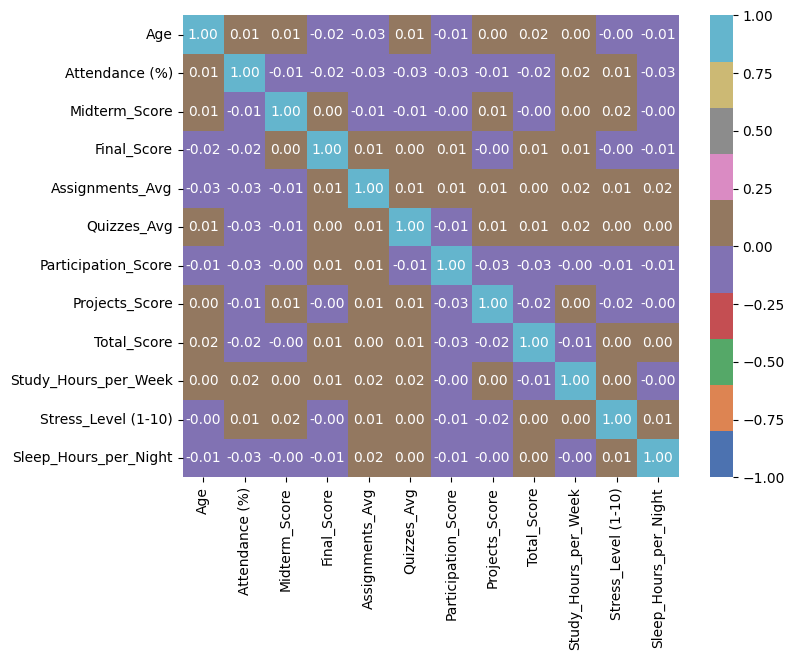

In [188]:

plt.figure(figsize=[8,6])
sns.heatmap(num_df.corr(),annot=True,vmin=-1,vmax=1,cmap=sns.color_palette(palette='deep'),fmt='.2f')
plt.show()

# Histograms

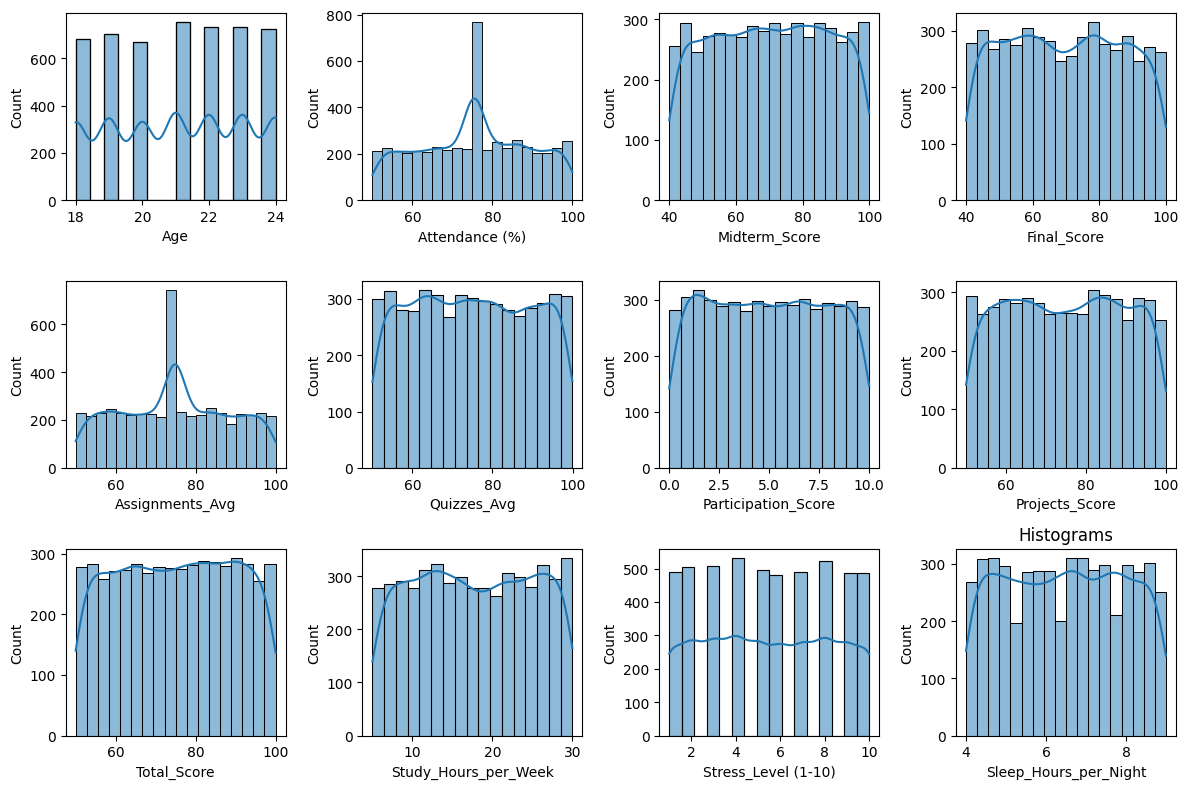

In [189]:
plt.figure(figsize=[12,8])
for plot,i in enumerate(num_df):
    plt.subplot(3,4,plot+1)
    sns.histplot(num_df[i],kde=True)
plt.title('Histograms')
plt.tight_layout()
plt.show()

# Box plot - outliers

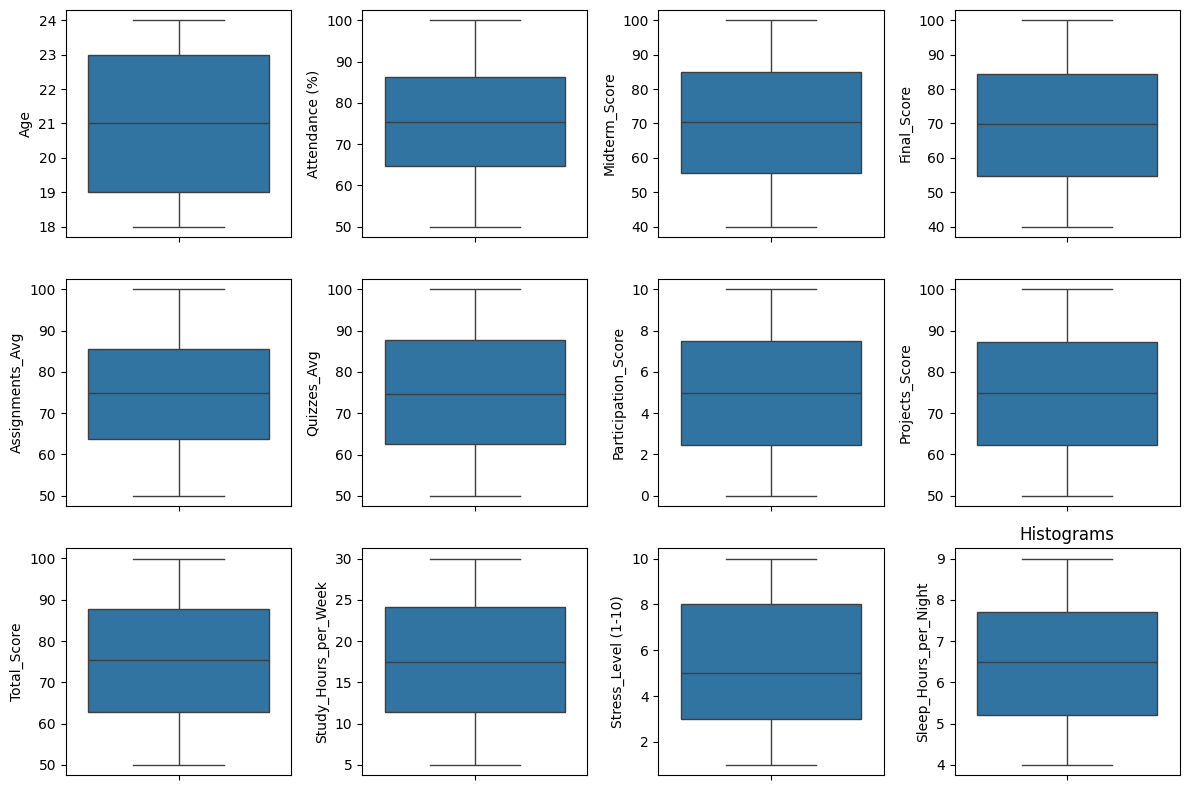

In [190]:
plt.figure(figsize=[12,8])
for plot,i in enumerate(num_df):
    plt.subplot(3,4,plot+1)
    sns.boxplot(num_df[i])
plt.title('Histograms')
plt.tight_layout()
plt.show()

# Modeling
Target = 'Grade' <br>
Features = rest of columns

In [191]:
X = df.drop('Grade',axis=1)
y = df['Grade']

# Split data to train test
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=11,test_size=.25)


## Encoding 

In [192]:
encoder_dict = {}
for i in X_train.select_dtypes(include='object'):
    encoder = LabelEncoder()
    X_train[i] = encoder.fit_transform(X_train[i])
    encoder_dict[i] = encoder

for i in  encoder_dict:
    X_test[i] = encoder_dict[i].transform(X_test[i])


## Class weight calculation


In [193]:
cls_weight = y_train.value_counts(normalize=True).reset_index()
cls_weight['weight'] = 1/cls_weight['proportion']
class_weight = dict(zip(cls_weight['Grade'],cls_weight['weight']))
class_weight

{'A': 3.351206434316354,
 'B': 5.1229508196721305,
 'D': 5.56379821958457,
 'F': 5.942947702060222,
 'C': 6.313131313131312}

## Classifier

In [194]:
clf = RandomForestClassifier(random_state=11)
clf.fit(X_train,y_train,y_train.map(class_weight))
print('r2 score - train data :',clf.score(X_train,y_train))

y_pred = clf.predict(X_test)

print('r2 score - test data :',clf.score(X_test,y_test))

r2 score - train data : 1.0
r2 score - test data : 0.3704


## Performance metrics


In [195]:
print('Classification report\n')
cr = classification_report(y_test,y_pred)
print(cr)

Classification report

              precision    recall  f1-score   support

           A       0.58      0.67      0.62       376
           B       0.17      0.09      0.12       246
           C       0.20      0.16      0.18       200
           D       0.29      0.38      0.33       215
           F       0.31      0.34      0.33       213

    accuracy                           0.37      1250
   macro avg       0.31      0.33      0.32      1250
weighted avg       0.34      0.37      0.35      1250



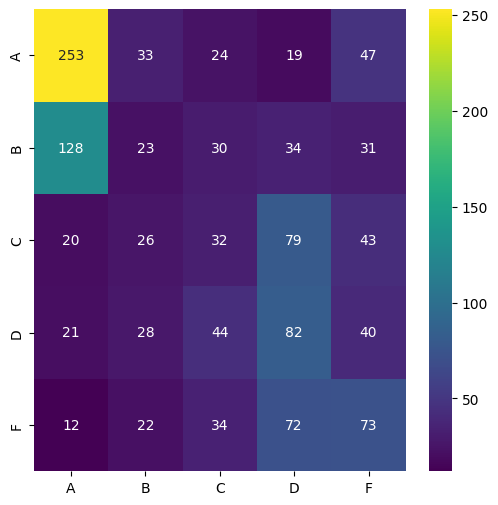

In [196]:
cm = confusion_matrix(y_test,y_pred)
plt.figure(figsize=[6,6])
labels = ['A','B','C','D','F']
sns.heatmap(cm,cmap='viridis',annot=True,fmt='d',xticklabels=labels,yticklabels=labels)
plt.show()

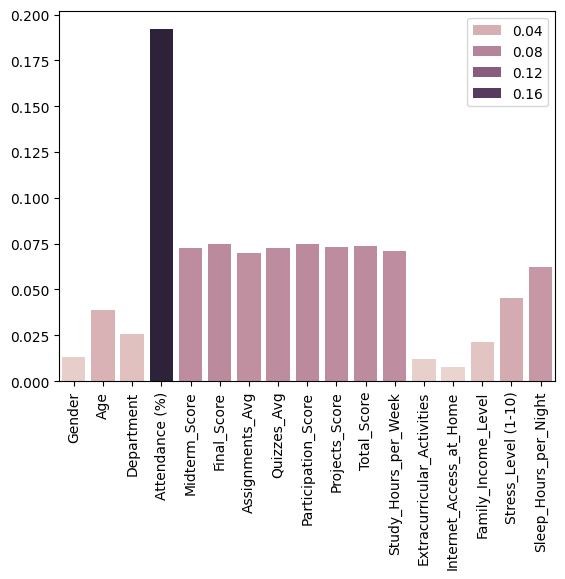

In [ ]:
y = clf.feature_importances_
x = clf.feature_names_in_

feature_importance = pd.DataFrame()
feature_importance['features'] = clf.feature_names_in_
feature_importance['importance'] = clf.feature_importances_

sns.barplot(x=x,y=y,hue=y)
plt.xticks(rotation =90)
plt.title('Feature importance')
plt.show()

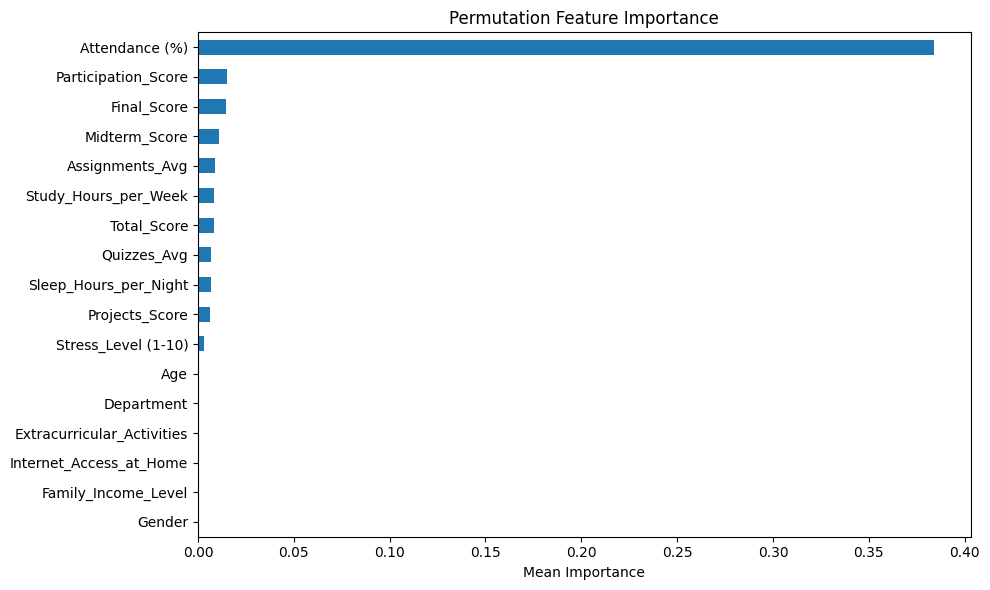

In [205]:
from sklearn.inspection import permutation_importance

# Run permutation importance
result = permutation_importance(clf, X_train, y_train, n_repeats=10, random_state=42)

# Convert to series and plot
perm_importance = pd.Series(result.importances_mean, index=X.columns).sort_values()
perm_importance.plot(kind='barh', figsize=(10,6), title="Permutation Feature Importance")
plt.xlabel("Mean Importance")
plt.tight_layout()
plt.show()

# Feature selection + remodeling

In [167]:
kbest = SelectKBest(f_classif,k=5)
new_features = kbest.fit_transform(X_train,y_train)

new_cols = X_train.columns[list(kbest.get_support())]

In [168]:
X_train_new = X_train[new_cols]
X_test_new = X_test[new_cols]

In [169]:
clf = RandomForestClassifier(random_state=11)
clf.fit(X_train_new,y_train)
clf.fit(X_train_new,y_train,y_train.map(class_weight))
print('r2 score - train data :',clf.score(X_train_new,y_train))

y_pred = clf.predict(X_test_new)

print('r2 score - test data :',clf.score(X_test_new,y_test))

r2 score - train data : 1.0
r2 score - test data : 0.3416


In [170]:
print('Classification report\n')
cr = classification_report(y_test,y_pred)
print(cr)

Classification report

              precision    recall  f1-score   support

           A       0.53      0.63      0.58       376
           B       0.20      0.13      0.16       246
           C       0.21      0.20      0.20       200
           D       0.26      0.29      0.27       215
           F       0.27      0.26      0.26       213

    accuracy                           0.34      1250
   macro avg       0.29      0.30      0.30      1250
weighted avg       0.32      0.34      0.33      1250



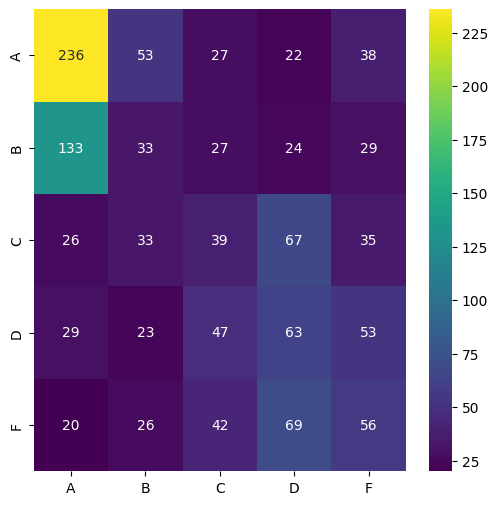

In [171]:
cm = confusion_matrix(y_test,y_pred)
plt.figure(figsize=[6,6])
labels = ['A','B','C','D','F']
sns.heatmap(cm,cmap='viridis',annot=True,fmt='d',xticklabels=labels,yticklabels=labels)
plt.show()

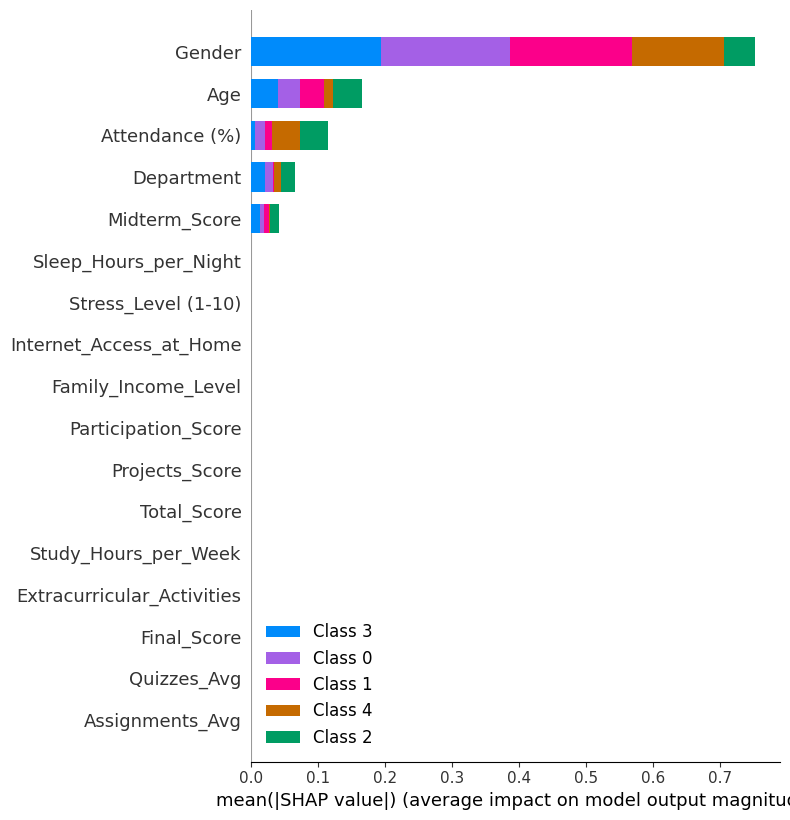

In [172]:
explainer = shap.Explainer(clf)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test)

<Axes: >

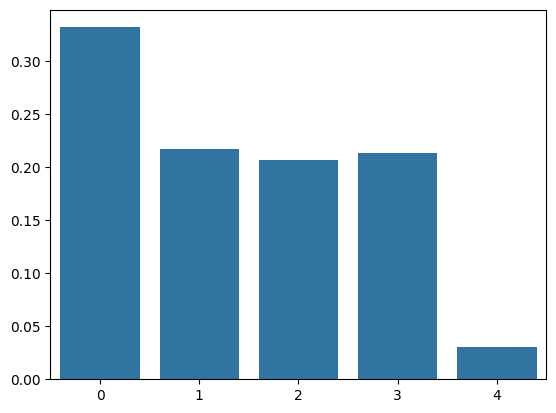

In [173]:
sns.barplot(clf.feature_importances_)